In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.font_manager import FontProperties
import pandapower as pp
import pandapower.plotting as plot
from multi_year_utils import *

In [1]:
CURRENT_SCENARIO = '3_worst_case'

In [3]:
TIMESTEPS = 35040 # 365 days with 15min resolution
V_REF = 1.0 # pu
V_NOM = 416 # V

working_folder = os.getcwd()
root_dir = os.path.abspath(os.path.join(working_folder, os.pardir))
root_dir = os.path.abspath(os.path.join(root_dir, os.pardir))
network_path = os.path.join(root_dir, 'data', CURRENT_SCENARIO,'network')
data_path = os.path.join(root_dir, 'data', CURRENT_SCENARIO)
output_dir = os.path.join(data_path, "time_series_calculation")

# load network
net = pp.from_json(os.path.join(network_path,'IEEE_modified_LV_Feeder.json'))
# importing timeseries data for plotting
bus_voltage_data_array_absolute, line_loading_data_array = load_time_series_results(output_dir, V_NOM)

In [4]:
# convert bus voltage back to pu
bus_voltage_data_array = bus_voltage_data_array_absolute / V_NOM

max_voltages = np.max(bus_voltage_data_array, axis=0)
min_voltages = np.min(bus_voltage_data_array, axis=0)

max_loadings = np.max(line_loading_data_array, axis=0)

### Plot max overloadings for every bus

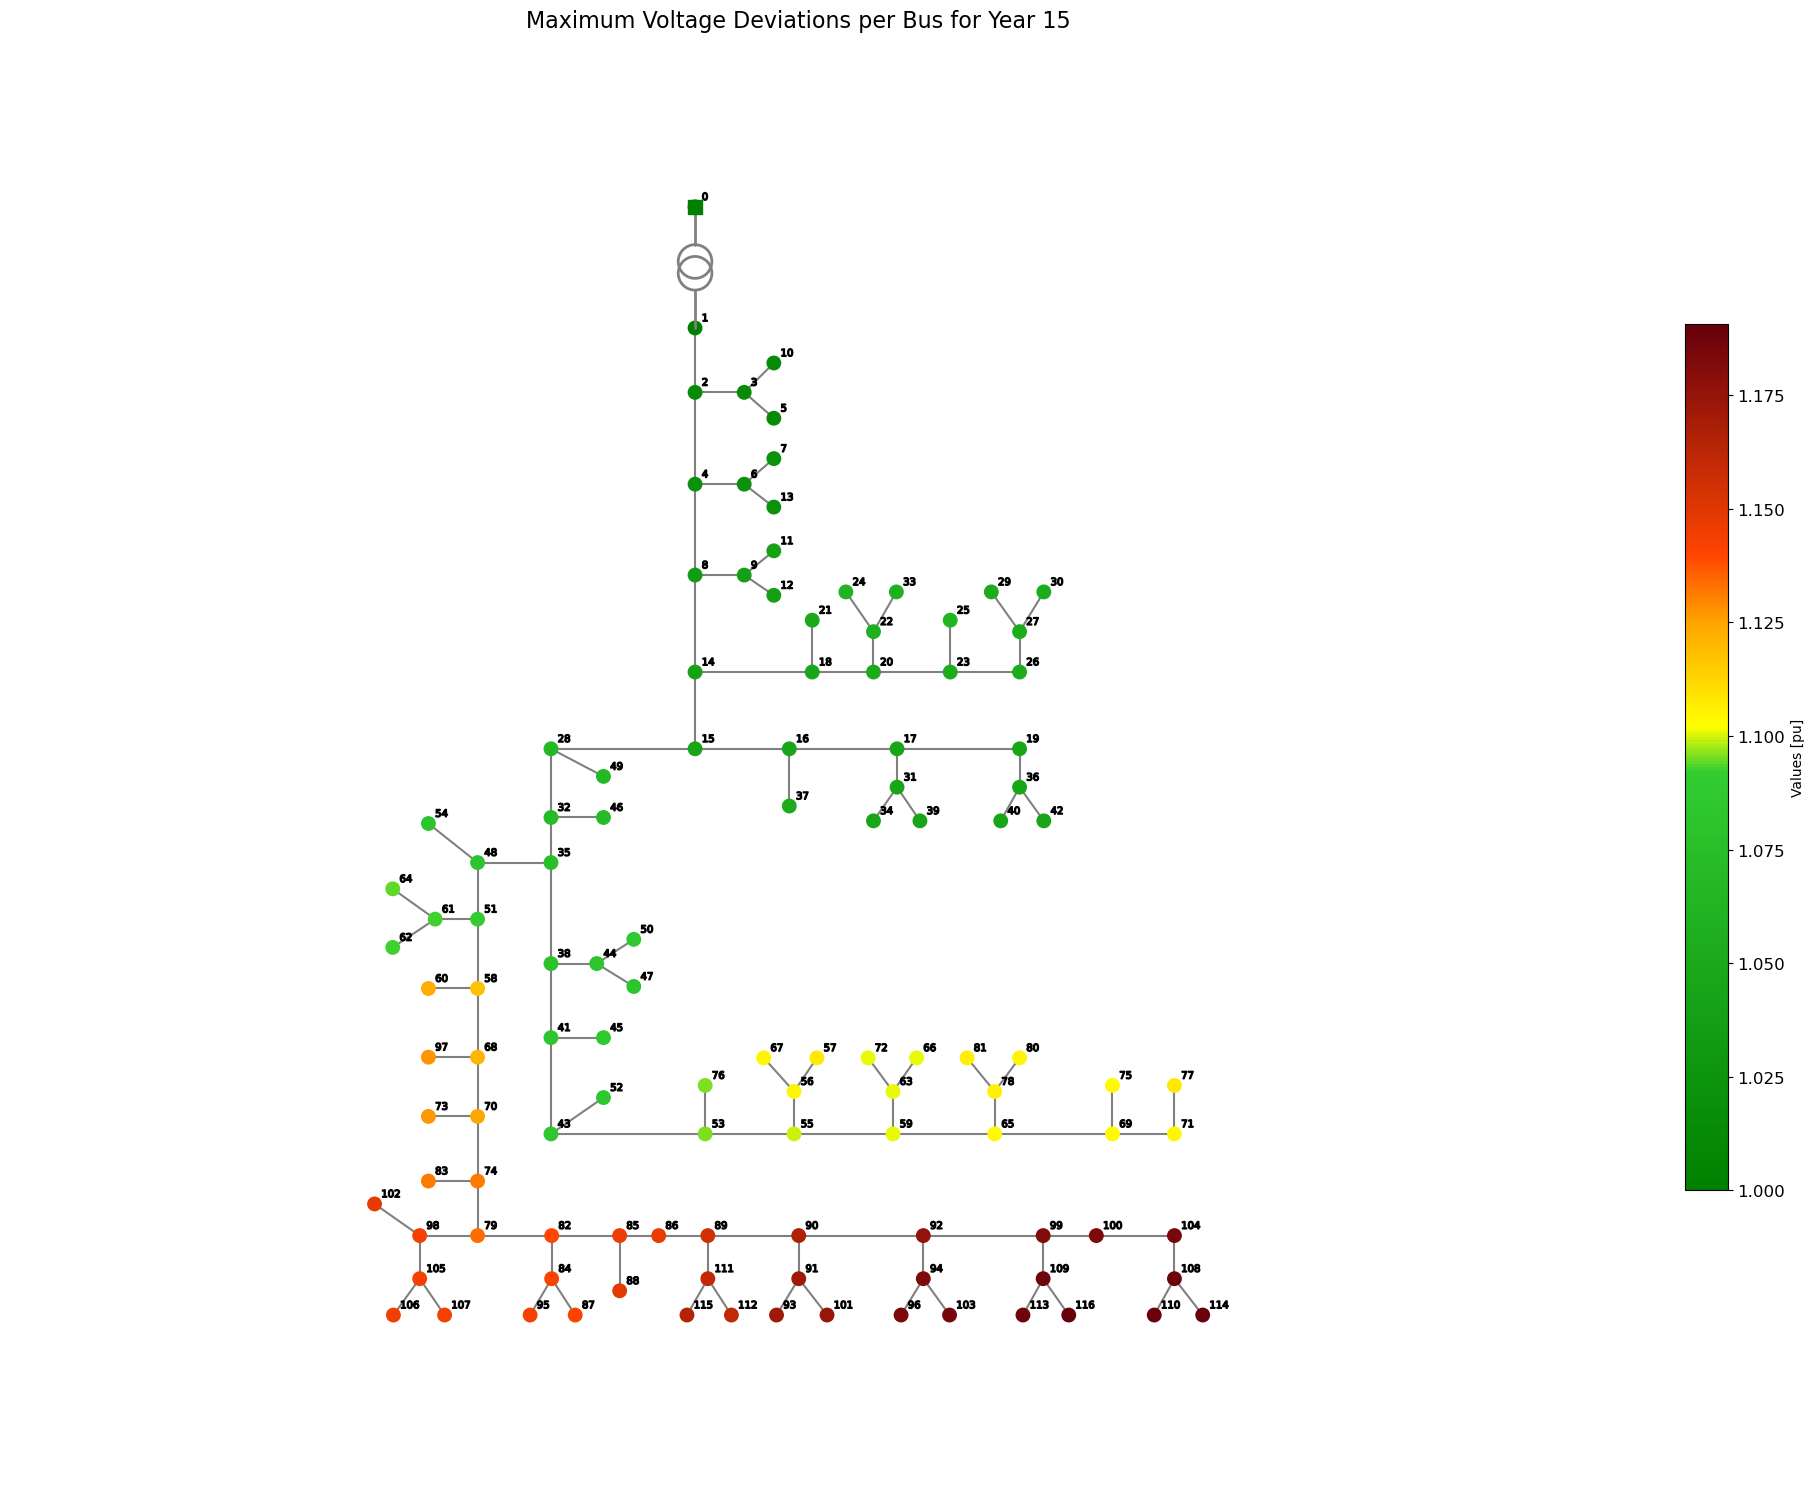

In [5]:
# Maximum voltage deviations per bus
fig, ax = plt.subplots(figsize=(20, 15))

# Create colormap based on the maxium voltage deviations for each bus
cmap_list = [(1.0, "green"), (1.092, "limegreen"), (1.102, "yellow"), (1.125, "orange"), (1.14, "orangered"), (np.max(max_voltages), (0.403921568627451, 0.0, 0.05098039215686274, 1.0))]
color_map, norm = plot.cmap_continuous(cmap_list)
# Create a ScalarMappable object for mapping the normalized data to colors
scalar_map = ScalarMappable(norm=norm, cmap=color_map)
# Create a list of colors corresponding to each value in max_voltages
colors = [scalar_map.to_rgba(value) for value in max_voltages]

#create colored buses 
bc = plot.create_bus_collection(net, net.bus.index, size=1.0, zorder=1, color=colors)
#plote bus ids
buses_list = list(net.bus.index) # list of all bus indices
coords = zip(net.bus_geodata.x.loc[buses_list].values + 1.0, net.bus_geodata.y.loc[buses_list].values + 1.0) # tuples of all bus coords
fp = FontProperties(weight="light")
bic = plot.create_annotation_collection(size=1.5, texts=np.char.mod('%d', buses_list), prop=fp, coords=coords, zorder=5, color="black")

#create lines
lc = plot.create_line_collection(net, net.line.index, color="grey", linewidths=1.5, use_bus_geodata=True, zorder=1)
#plot transformer
tlc, tpc = plot.create_trafo_collection(net, net.trafo.index, color="grey",size =2.5)
#plot grid
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=1.0, color="g", zorder=11)

# Draw the collections on the subplot
plot.draw_collections([lc, bc, bic, tlc, tpc, sc], ax=ax)

cbar = plt.colorbar(scalar_map, ax=ax, label='Values [pu]', shrink=0.6, aspect=20)
cbar.ax.tick_params(labelsize=12)  # Adjust colorbar tick label size
plt.title('Maximum Voltage Deviations per Bus for Year 15', fontsize=16)
# Adjust spacing
plt.tight_layout()
plt.show()

### Plot min overloadings for every bus

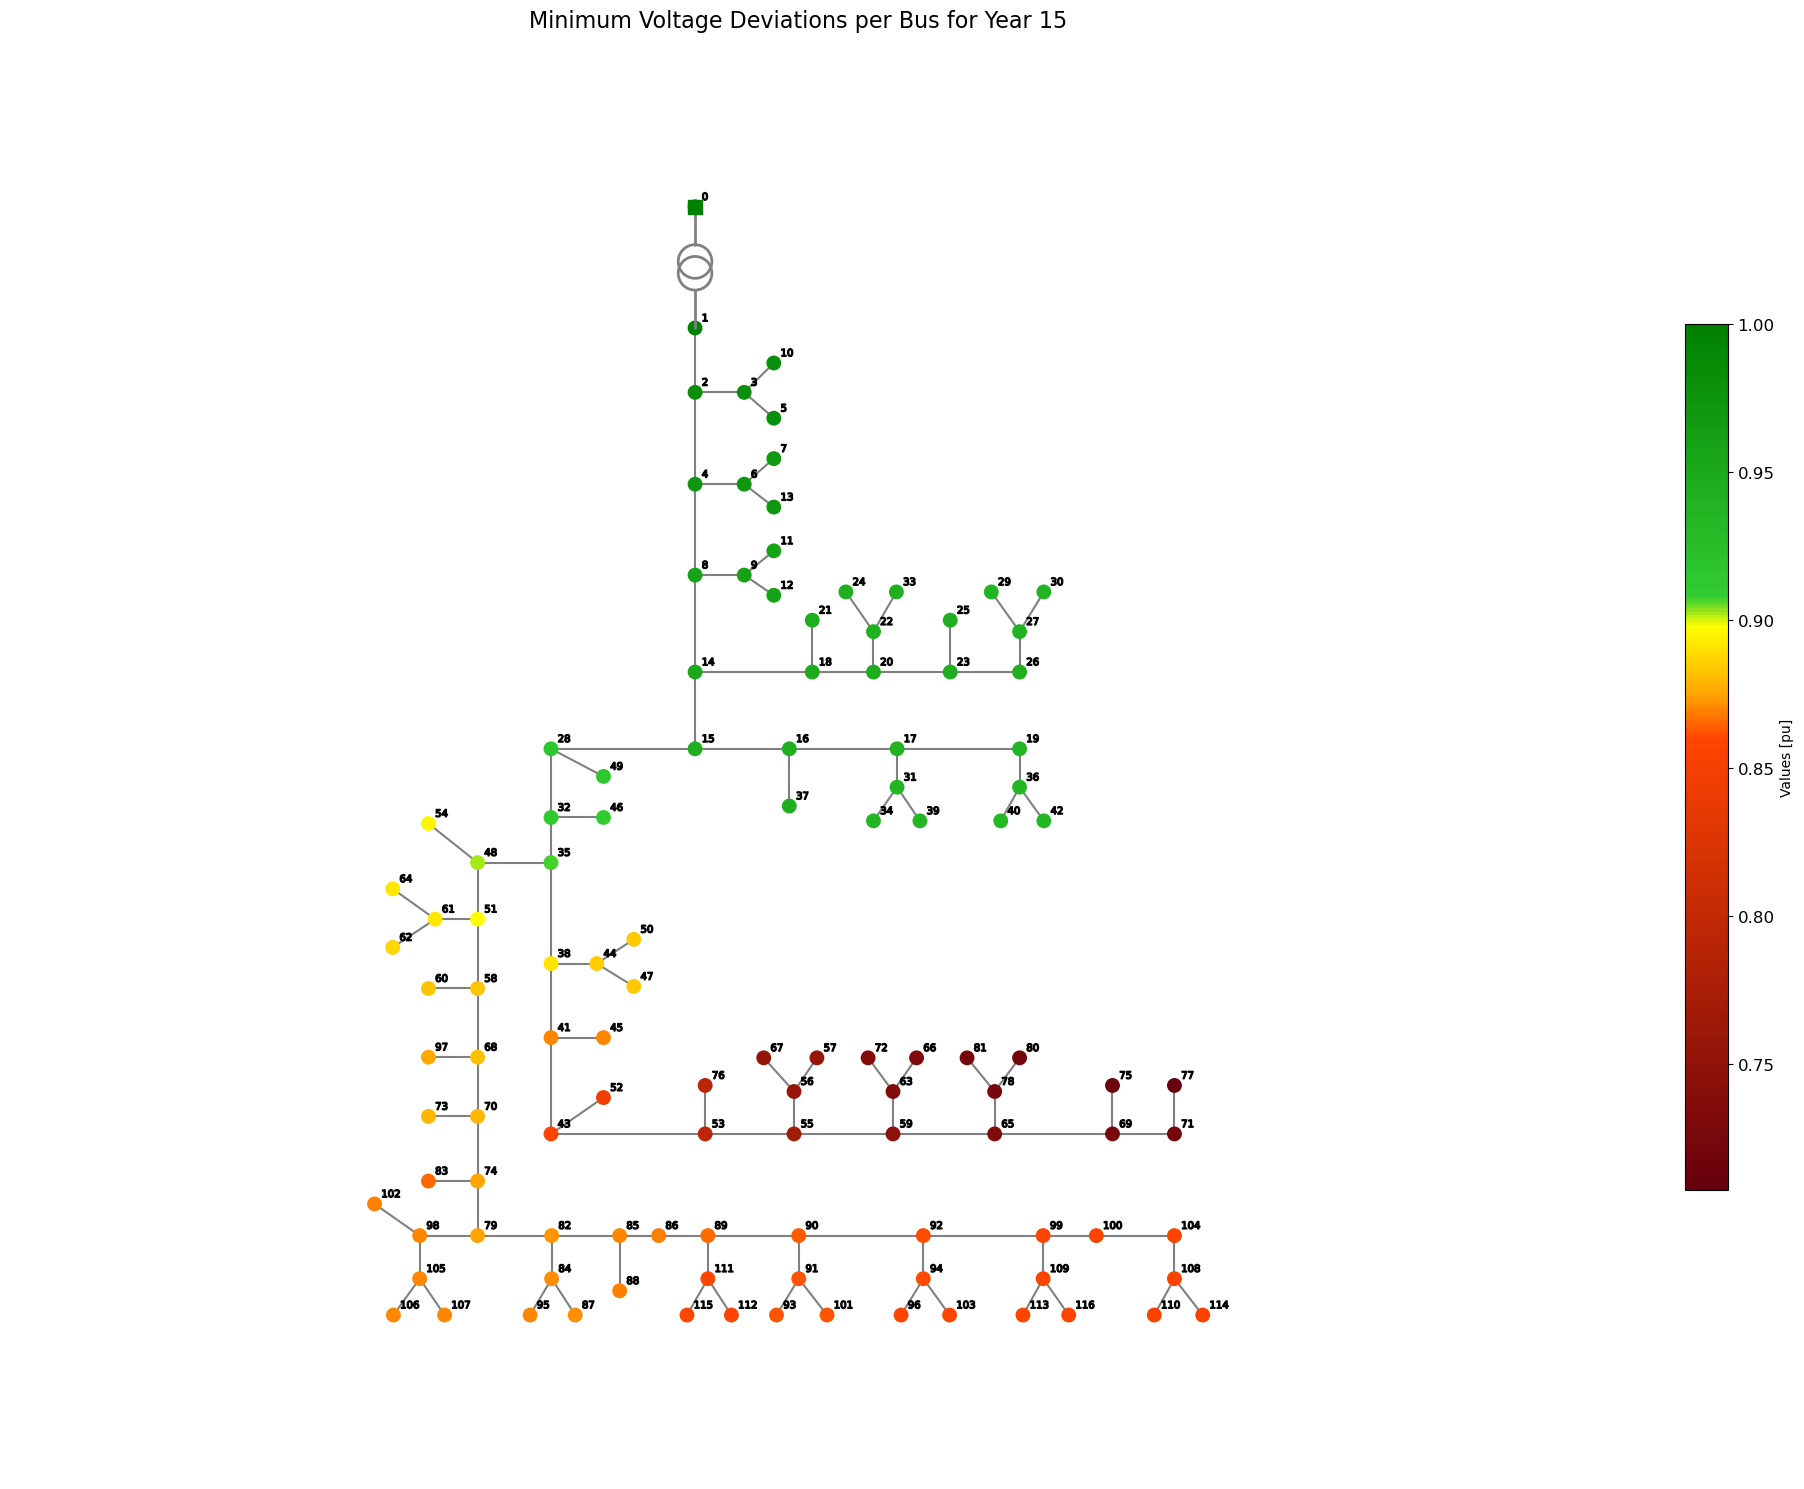

In [6]:
# Minimum voltage deviations per bus

fig, ax = plt.subplots(figsize=(20, 15))

# Create colormap based on the minimum voltage deviations for each bus
cmap_list = [(np.min(min_voltages), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)), (.86, "orangered"), (.875, "orange"), (.898, "yellow"), (.908, "limegreen"), (1.0, "green")]
color_map, norm = plot.cmap_continuous(cmap_list)
# Create a ScalarMappable object for mapping the normalized data to colors
scalar_map = ScalarMappable(norm=norm, cmap=color_map)
# Create a list of colors corresponding to each value in max_voltages
colors = [scalar_map.to_rgba(value) for value in min_voltages]

#create colored buses 
bc = plot.create_bus_collection(net, net.bus.index, size=1.0, zorder=1, color=colors)
#plote bus ids
buses_list = list(net.bus.index) # list of all bus indices
coords = zip(net.bus_geodata.x.loc[buses_list].values + 1.0, net.bus_geodata.y.loc[buses_list].values + 1.0) # tuples of all bus coords
fp = FontProperties(weight="light")
bic = plot.create_annotation_collection(size=1.5, texts=np.char.mod('%d', buses_list), prop=fp, coords=coords, zorder=5, color="black")

#create lines
lc = plot.create_line_collection(net, net.line.index, color="grey", linewidths=1.5, use_bus_geodata=True, zorder=1)
#plot transformer
tlc, tpc = plot.create_trafo_collection(net, net.trafo.index, color="grey",size =2.5)
#plot grid
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=1.0, color="g", zorder=11)

# Draw the collections on the subplot
plot.draw_collections([lc, bc, bic, tlc, tpc, sc], ax=ax)

cbar = plt.colorbar(scalar_map, ax=ax, label='Values [pu]', shrink=0.6, aspect=20)
cbar.ax.tick_params(labelsize=12)  # Adjust colorbar tick label size
plt.title('Minimum Voltage Deviations per Bus for Year 15', fontsize=16)
# Adjust spacing
plt.tight_layout()
plt.show()

In [6]:
# Define possible SVR positions by looking at the graph

SVR_POS = [(51,58), (74,79), (86,89), (35,38), (43,53)]

# Current rating will be defined by the maximum current passing in year 15 through the line that the SVR is installed.
    # This is needed to be decided beforehand, in order to take into account the capital cost of the SVR.
    # However the actual current rating might be much smaller, as a result also the CAPEX, after the optimization has decided on technologies/ways to upgrade the network and mitigate contigencies.

In [7]:
# Find the required current ratings for the SVRs

line_fbus = net.line.from_bus
line_tbus = net.line.to_bus
line_bus_tuples = list(zip(line_fbus, line_tbus))  # List of tuples (fbus, tbus)
max_loadings_dict = dict(zip(line_bus_tuples, max_loadings))
for fbus,tbus in SVR_POS:
    print(max_loadings_dict[fbus,tbus])

98.0202696104
80.5665167325
72.6936808366
160.3323229263
150.850161624


In [6]:
# Get the bus geodata for the lines
line_geodata = {}
for line_idx in net.line.index:
    from_bus_idx = net.line.at[line_idx, 'from_bus']
    to_bus_idx = net.line.at[line_idx, 'to_bus']
    
    fbus_x = net.bus_geodata.at[from_bus_idx, 'x']
    fbus_y = net.bus_geodata.at[from_bus_idx, 'y']
    tbus_x = net.bus_geodata.at[to_bus_idx, 'x']
    tbus_y = net.bus_geodata.at[to_bus_idx, 'y']
    
    # Calculate middle point of the line
    middle_point = ((fbus_x + tbus_x) / 2, (fbus_y + tbus_y) / 2)
    
    line_geodata[line_idx] = middle_point

# Save the middle points
line_coords = [(coord[0], coord[1]) for coord in line_geodata.values()]

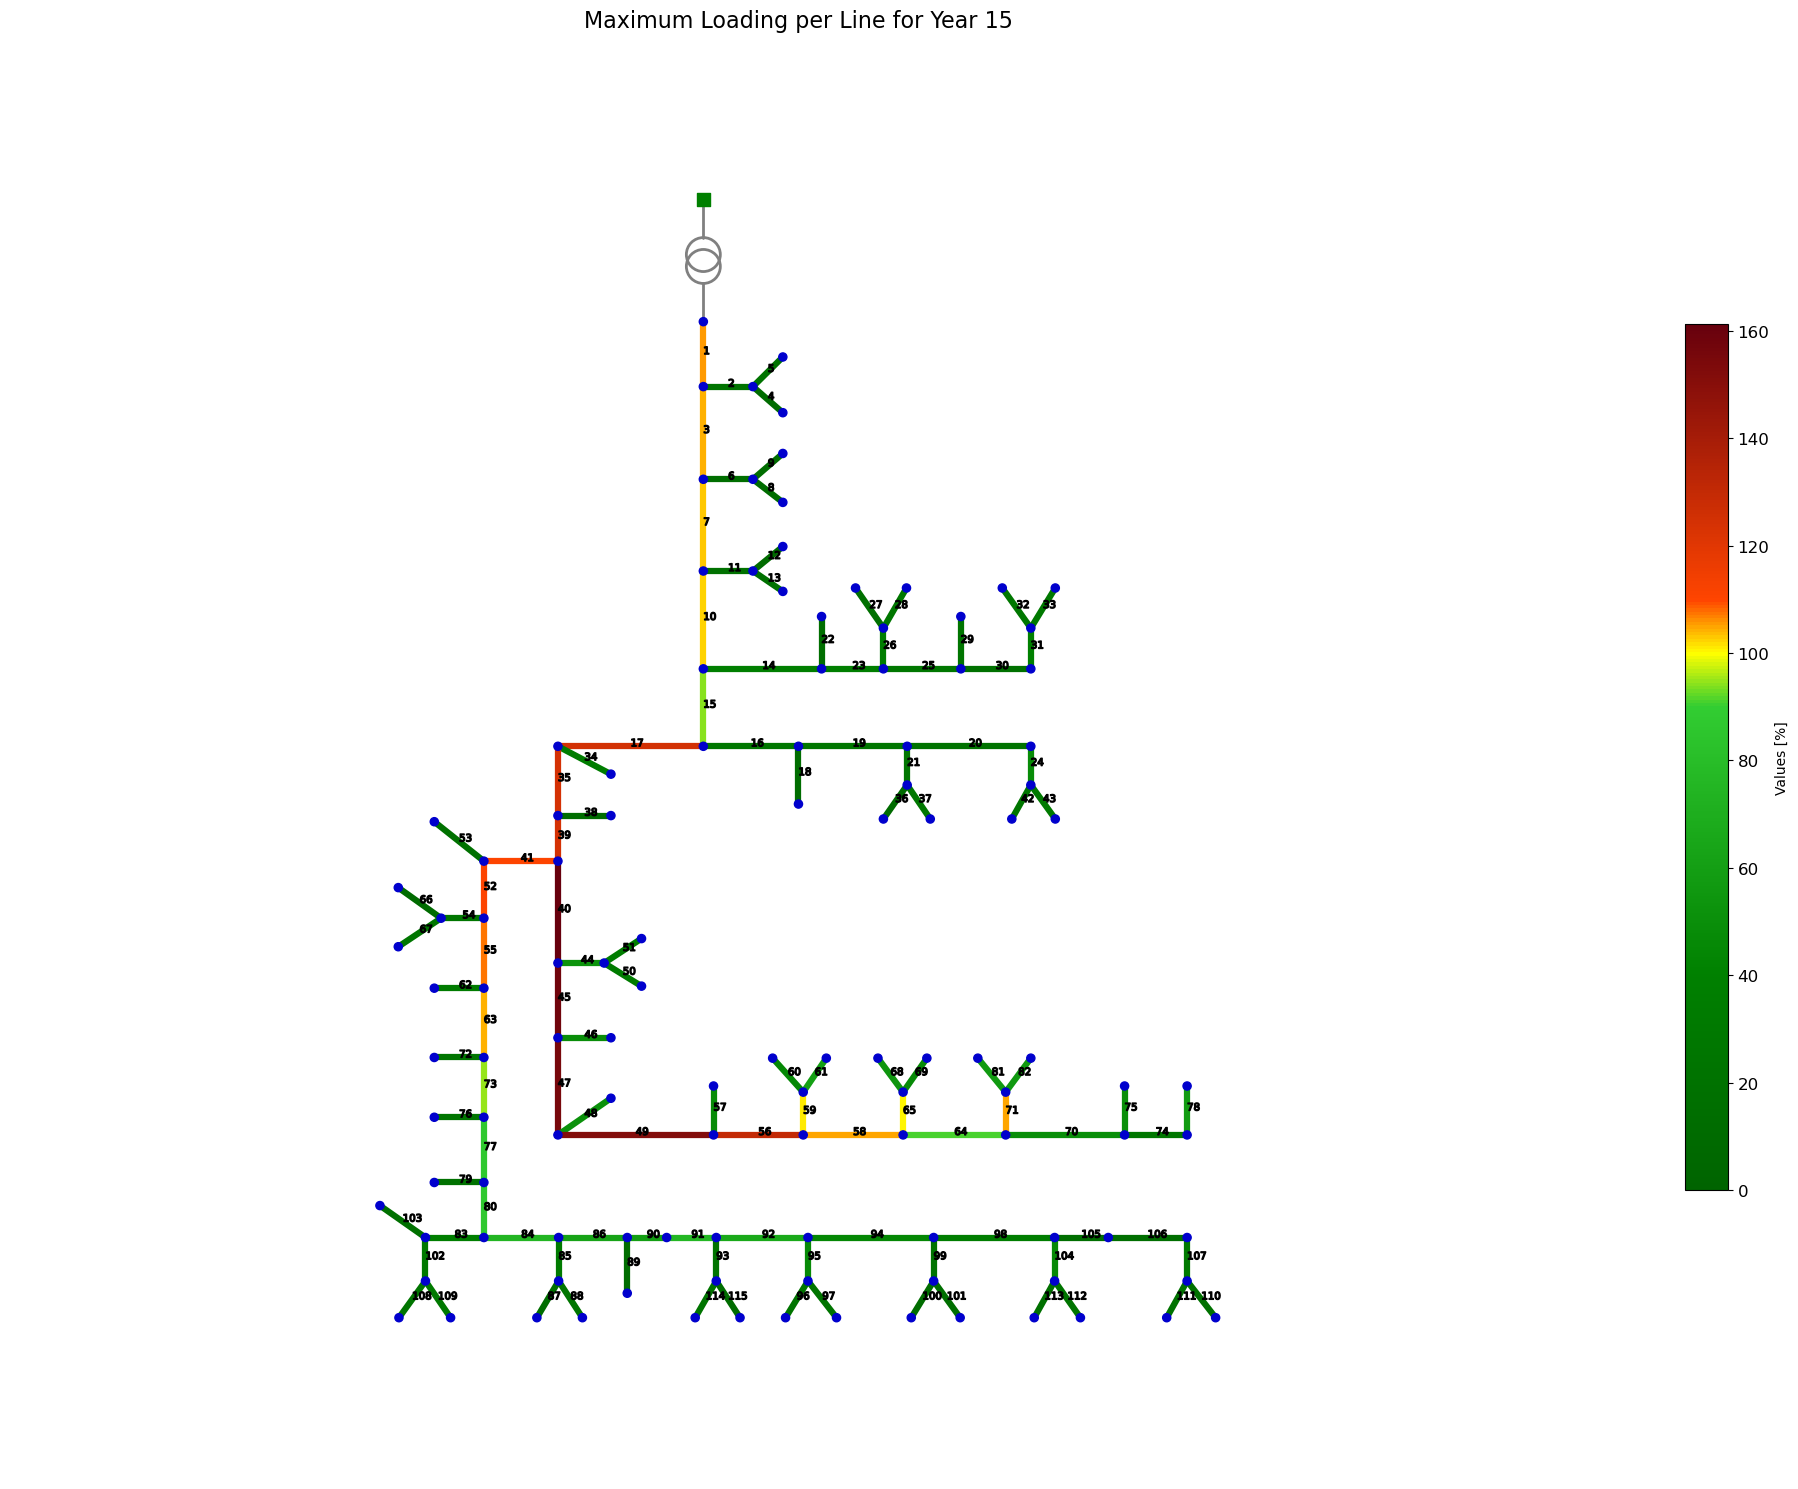

In [7]:
# Maximum line loadings per line

fig, ax = plt.subplots(figsize=(20, 15))

# Create colormap based on the maximum line loadings for each bus
cmap_list = [(0, "darkgreen"), (40, "green"), (90, "limegreen"), (100, "yellow"), (105, "orange"), (110, "orangered"), (np.max(max_loadings), (0.403921568627451, 0.0, 0.05098039215686274, 1.0))]
color_map, norm = plot.cmap_continuous(cmap_list)
# Create a ScalarMappable object for mapping the normalized data to colors
scalar_map = ScalarMappable(norm=norm, cmap=color_map)
# Create a list of colors corresponding to each value in max_loadings
colors = [scalar_map.to_rgba(value) for value in max_loadings]

#create colored lines
lc = plot.create_line_collection(net, net.line.index, color=colors, linewidths=4.5, use_bus_geodata=True, zorder=1)
#plot line ids
lines_list = list(net.line.index + 1) # list of all bus indices
fp = FontProperties(weight="light")
bic = plot.create_annotation_collection(size=1.5, texts=np.char.mod('%d', lines_list), prop=fp, coords=line_coords, zorder=5, color="black")

#create buses 
bc = plot.create_bus_collection(net, net.bus.index, size=0.6, zorder=11, color="mediumblue")
#plot transformer
tlc, tpc = plot.create_trafo_collection(net, net.trafo.index, color="grey",size =2.5)
#plot grid
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=1.0, color="g", zorder=11)

# Draw the collections on the subplot
plot.draw_collections([lc, bc, bic, tlc, tpc, sc], ax=ax)

cbar = plt.colorbar(scalar_map, ax=ax, label='Values [%]', shrink=0.6, aspect=20)
cbar.ax.tick_params(labelsize=12)  # Adjust colorbar tick label size
plt.title('Maximum Loading per Line for Year 15', fontsize=16)
# Adjust spacing
plt.tight_layout()
plt.show()

In [10]:
# Define possible Battery positions by looking at the graph. Battery nodes should not be load or generator nodes!!

BAT_POS = [14, 35, 43, 55, 68]

In [ ]:
# Find the required battery energy capacity

In [9]:
# Find lines that might need replacement

overloaded_lines = {i: value for i, value in enumerate(max_loadings) if value > 100}
overloaded_lines_info = net.line.loc[list(overloaded_lines)]
columns_to_drop = ['c_nf_per_km', 'g_us_per_km', 'df', 'parallel', 'in_service']
overloaded_lines_info = overloaded_lines_info.drop(columns=columns_to_drop)

# Multiply 'max_i_ka' column by 1000 and rename to 'max_i_a'
overloaded_lines_info['max_i_a'] = overloaded_lines_info['max_i_ka'] * 1000
overloaded_lines_info = overloaded_lines_info.drop(columns=['max_i_ka'])  # Drop the old column

# Add a new column 'overload_percent' to the DataFrame with default value None
overloaded_lines_info['overload_percent'] = None
# Update the 'overload_percent' column with values from the overloaded_lines dictionary
for idx, value in overloaded_lines.items():
    overloaded_lines_info.loc[idx, 'overload_percent'] = value
overloaded_lines_info['overload_i_a'] = overloaded_lines_info['overload_percent'] * overloaded_lines_info['max_i_a'] / 100
#overloaded_lines_info.to_csv(os.path.join(data_path,'upgrades','output.csv'), index=False)


In [10]:
overloaded_lines_info

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,type,max_i_a,overload_percent,overload_i_a
0,line1,4c_.35,1,2,0.087453,0.089,0.0675,ol,497.0,105.493522,524.302804
2,line3,4c_.35,2,4,0.050490,0.089,0.0675,ol,497.0,103.936861,516.566199
6,line7,4c_.35,4,8,0.084622,0.089,0.0675,ol,497.0,103.096507,512.389641
9,line10,4c_.35,8,14,0.053505,0.089,0.0675,ol,497.0,102.586342,509.85412
16,line17,4c_185,15,28,0.112747,0.166,0.0680,cs,348.0,125.2627,435.914197
34,line35,4c_185,28,32,0.016278,0.166,0.0680,cs,348.0,124.546674,433.422425
38,line39,4c_185,32,35,0.019965,0.166,0.0680,cs,348.0,124.166296,432.098711
39,line40,4c_.06,35,38,0.032921,0.469,0.0750,ol,210.0,161.232598,338.588457
40,line41,4c_.1,35,48,0.029207,0.274,0.0730,ol,270.0,110.51707,298.39609
44,line45,4c_.06,38,41,0.042718,0.469,0.0750,ol,210.0,157.800453,331.380951
